![GAN_cats](Project_6_pic_1.png)

<span style="font-size:24px">**Generative adversarial networks**</span>

We will train a GAN to generate human faces and examine how we can evaluate the quality of the generated faces.

## Installing Dependencies

In [ ]:
import os
import pandas as pd
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import torchvision.utils
sns.set(style='darkgrid', font_scale=1.2)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.manifold import TSNE
import plotly.express as px

### Data Preparation

As the training dataset, we will use a portion of the [Flickr Faces](https://github.com/NVlabs/ffhq-dataset) dataset, which contains high-resolution (1024x1024) images of human faces. The original dataset is very large, so we will work with a subset of it. 

Let's load our images. Write a function that constructs a DataLoader for the images, resizing them to the desired size (as the size of 1024 is too large, we will use a size of 64 pixels).

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
!ls /content/gdrive/

MyDrive


In [ ]:
!ls -l /content/gdrive/MyDrive/thumbnails128x128.zip

-rw------- 1 root root 2007027060 Dec 27 08:31 /content/gdrive/MyDrive/thumbnails128x128.zip


Let's unpack our photos.

In [ ]:
!unzip -q /content/gdrive/MyDrive/thumbnails128x128.zip

replace thumbnails128x128/LICENSE.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


Let's specify the path to the folder containing the files.

In [ ]:
DATA_DIR = './thumbnails128x128/'

In [ ]:
def get_dataloader(image_size, batch_size):
  """
  this function resizes the images, converts them to tensors, and builds a dataloader
  param image_size: height and wdith of the image
  param batch_size: batch_size of the dataloader
  """
  transform = tt.Compose([tt.Resize(image_size),
                           tt.ToTensor(),
                           tt.Normalize(*stats)])
  dataset = ImageFolder(DATA_DIR, transform)
  dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
  return dataloader

We chose a size of 64x64 because with an image_size of 128x128, the Google Colab GPU tends to crash quickly and does not allow for a reasonable number of epochs to be completed. The optimal batch size is 128.

In [ ]:
# building the dataloader and transfer it to device
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
dataloader = get_dataloader(image_size, batch_size)

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

Let's see how our batch looks like.

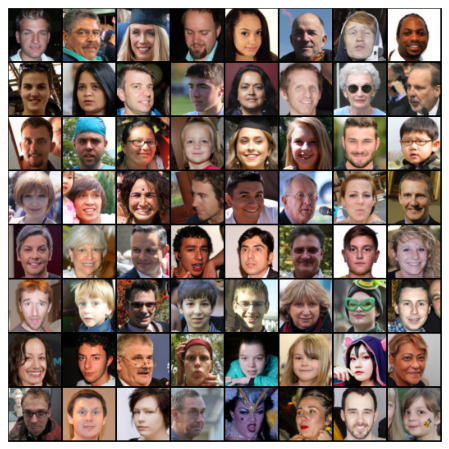

In [ ]:
show_batch(dataloader)

In [ ]:
def to_device(data, device):
    # we move tensor(s) to chosen device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    # we wrap a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        # we yield a batch of data after moving it to device
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        # number of batches
        return len(self.dl)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
dataloader = DeviceDataLoader(dataloader, device)

## Building and Training the Model

Let's construct a generator and a discriminator.
* The discriminator takes an input image (a tensor of size `3 x image_size x image_size`) and outputs the probability that the image is real (a tensor of size 1).
* The generator takes an input tensor of noise with size `latent_size x 1 x 1` and generates an image of size `3 x image_size x image_size`

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 64

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

Let's build and examine the noise from which the images are generated.

torch.Size([128, 3, 64, 64])


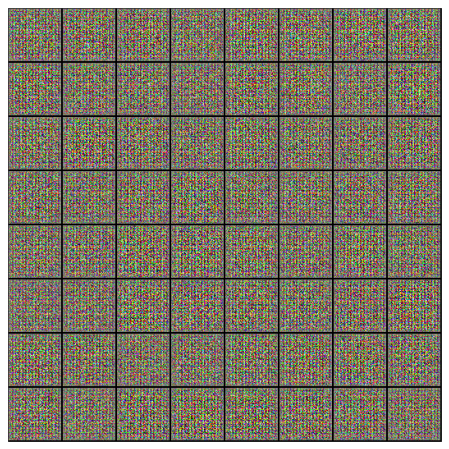

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) 
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Let's now move on to training our GAN. The training algorithm is as follows:
1. Train the discriminator:
* Take real images and assign them the label 1.
* Generate images using the generator and assign them the label 0.
* Train the discriminator as a binary classifier.
2. Train the generator:
* Generate images using the generator and assign them the label 0.
* Use the discriminator to predict whether the generated images are real or not.
For the loss function, we use binary cross-entropy.

5 epochs took about 15 minutes on Google Colab GPU. Let's try doubling it to 50 epochs with a learning rate of 0.0002.  

Based on my opinion, a batch size of 128 seems to be optimal. I didn't notice any significant differences between different learning rates, and we didn't apply any schedulers. We used the classic optimizer - Adam.  

We trained for 75 epochs (around 3 hours), but the result was lost due to incorrect model weight saving. We couldn't measure the score, but based on the visuals, the generated images seemed similar to the ones from 50 epochs.

In [ ]:
lr = 0.0002
model = {
    "discriminator": discriminator,
    "generator": generator
}
criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}
epochs = 50

In [ ]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # creating optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(dataloader):
            # training discriminator
            # clearing discriminator gradients
            optimizer["discriminator"].zero_grad()

            # passing real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # generating fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # passing fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # updating discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # training generator
            # clearing generator gradients
            optimizer["generator"].zero_grad()
            
            # generating fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # attempts to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # updating generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # recording losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
        # saving generated images
        if epoch == epochs - 1:
          save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [26]:
history = fit(model, criterion, epochs, lr)

  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 5.1318, loss_d: 0.5862, real_score: 0.8075, fake_score: 0.1925


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 3.7260, loss_d: 0.6941, real_score: 0.7583, fake_score: 0.2392


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 3.4143, loss_d: 0.6754, real_score: 0.7647, fake_score: 0.2319


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 3.5194, loss_d: 0.6166, real_score: 0.7837, fake_score: 0.2130


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 3.4606, loss_d: 0.5835, real_score: 0.7938, fake_score: 0.2043


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 3.3026, loss_d: 0.5805, real_score: 0.7998, fake_score: 0.1994


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 3.1186, loss_d: 0.5997, real_score: 0.7980, fake_score: 0.1995


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 3.1715, loss_d: 0.5497, real_score: 0.8093, fake_score: 0.1896


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 3.2231, loss_d: 0.5182, real_score: 0.8189, fake_score: 0.1801


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 3.2375, loss_d: 0.5279, real_score: 0.8201, fake_score: 0.1797


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 3.1850, loss_d: 0.5279, real_score: 0.8265, fake_score: 0.1722


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 3.2411, loss_d: 0.4584, real_score: 0.8428, fake_score: 0.1571


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 3.3089, loss_d: 0.4579, real_score: 0.8441, fake_score: 0.1552


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 3.3490, loss_d: 0.4748, real_score: 0.8464, fake_score: 0.1533


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 3.3720, loss_d: 0.4047, real_score: 0.8659, fake_score: 0.1338


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 3.3076, loss_d: 0.4131, real_score: 0.8654, fake_score: 0.1341


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 3.5805, loss_d: 0.3778, real_score: 0.8744, fake_score: 0.1253


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 3.6727, loss_d: 0.2715, real_score: 0.9003, fake_score: 0.0992


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 3.4237, loss_d: 0.5412, real_score: 0.8492, fake_score: 0.1509


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 3.6925, loss_d: 0.3254, real_score: 0.8942, fake_score: 0.1053


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 3.6231, loss_d: 0.3748, real_score: 0.8841, fake_score: 0.1161


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 3.7132, loss_d: 0.3139, real_score: 0.9000, fake_score: 0.0996


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 3.8153, loss_d: 0.3268, real_score: 0.9010, fake_score: 0.0999


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 3.8091, loss_d: 0.3833, real_score: 0.8885, fake_score: 0.1107


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 3.6989, loss_d: 0.3185, real_score: 0.8959, fake_score: 0.1036


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 4.0211, loss_d: 0.2421, real_score: 0.9182, fake_score: 0.0814


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 3.8257, loss_d: 0.3699, real_score: 0.8931, fake_score: 0.1069


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 3.8610, loss_d: 0.3635, real_score: 0.8947, fake_score: 0.1053


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 4.1063, loss_d: 0.2431, real_score: 0.9238, fake_score: 0.0759


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 4.0275, loss_d: 0.2663, real_score: 0.9169, fake_score: 0.0827


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 4.1294, loss_d: 0.3448, real_score: 0.9059, fake_score: 0.0942


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 4.1069, loss_d: 0.2585, real_score: 0.9226, fake_score: 0.0769


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 4.2352, loss_d: 0.1910, real_score: 0.9348, fake_score: 0.0651


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 4.1478, loss_d: 0.3933, real_score: 0.9247, fake_score: 0.0762


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 4.1130, loss_d: 0.3221, real_score: 0.9157, fake_score: 0.0845


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 4.1179, loss_d: 0.3198, real_score: 0.9079, fake_score: 0.0918


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 4.1500, loss_d: 0.2835, real_score: 0.9163, fake_score: 0.0835


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 4.3637, loss_d: 0.2244, real_score: 0.9333, fake_score: 0.0667


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 4.3798, loss_d: 0.2691, real_score: 0.9225, fake_score: 0.0774


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 4.4743, loss_d: 0.1612, real_score: 0.9463, fake_score: 0.0535


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 4.5125, loss_d: 0.2681, real_score: 0.9316, fake_score: 0.0686


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 4.3754, loss_d: 0.2395, real_score: 0.9295, fake_score: 0.0702


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 4.3850, loss_d: 0.2244, real_score: 0.9315, fake_score: 0.0683


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 4.4388, loss_d: 0.2638, real_score: 0.9257, fake_score: 0.0743


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 4.8916, loss_d: 0.0932, real_score: 0.9660, fake_score: 0.0338


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 4.6064, loss_d: 0.2690, real_score: 0.9288, fake_score: 0.0712


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 4.6757, loss_d: 0.2232, real_score: 0.9379, fake_score: 0.0620


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 4.9469, loss_d: 0.1391, real_score: 0.9588, fake_score: 0.0410


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 4.6424, loss_d: 0.2472, real_score: 0.9352, fake_score: 0.0648


  0%|          | 0/512 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 4.7209, loss_d: 0.2759, real_score: 0.9251, fake_score: 0.0749
Saving generated-images-0050.png


Let's plot the loss graphs for the generator and discriminator.

In [27]:
losses_g, losses_d, real_scores, fake_scores = history

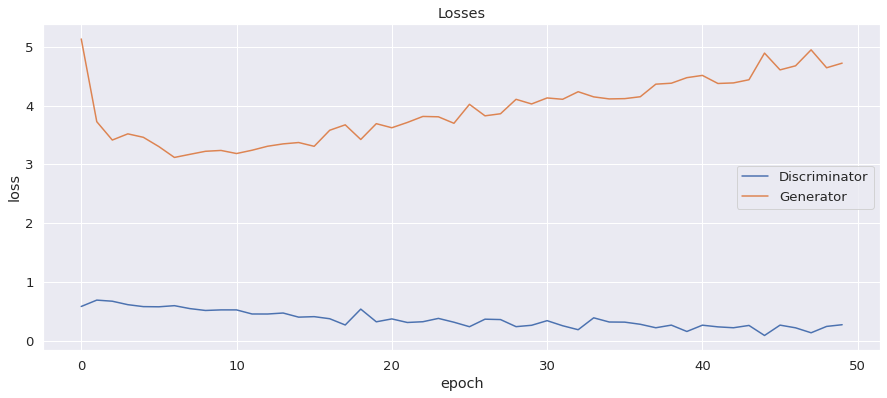

In [28]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

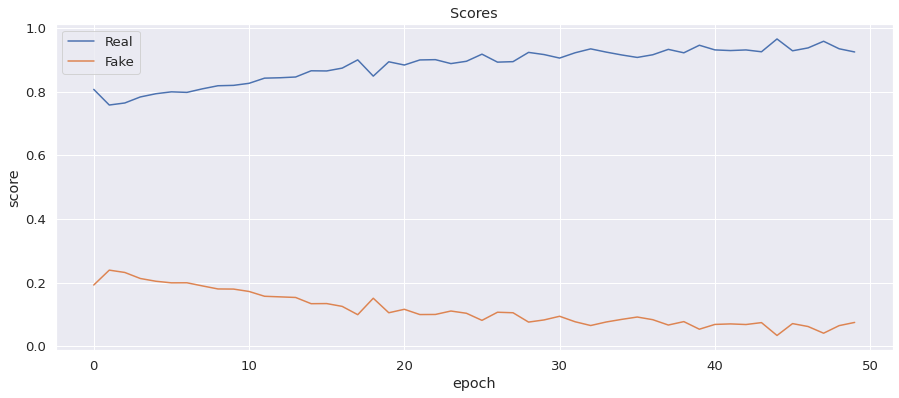

In [29]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

What can we say about these graphs?

* They correspond quite well to normal behavior: the generator's loss increases with each epoch, while the discriminator's loss decreases.
* The score for real images tends to approach 1, and for fake images, it tends to approach 0. The discriminator is learning to distinguish faces better and better. It would be possible to train for 100+ epochs, and the result would be even better.

## Image Generation

Now, let's evaluate the quality of the generated images and display 64 face images from the final, 50th epoch.

In [31]:
generated_img = cv2.imread(f'./generated/generated-images-00{epochs}.png')
generated_img = generated_img[:, :, [2, 1, 0]]

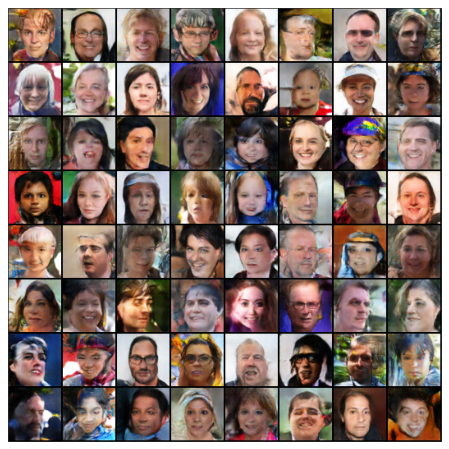

In [32]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)

Let's save the parameters of the successful model to load them later for solving future tasks.

In [35]:
# saving model
optimizer = {
"discriminator": torch.optim.Adam(model['discriminator'].parameters(),
lr=lr, betas=(0.5, 0.999)),
"generator": torch.optim.Adam(model['generator'].parameters(),
lr=lr, betas=(0.5, 0.999)),
}
checkpoint_g = {
'model': model['generator'],
'state_dict': model["generator"].state_dict(),
'optimizer': optimizer["generator"].state_dict()
}
checkpoint_d = {
'model': model['discriminator'],
'state_dict': model["discriminator"].state_dict(),
'optimizer': optimizer["discriminator"].state_dict()
}

In [36]:
torch.save(checkpoint_g, "/content/gdrive/MyDrive/generator.pth")
torch.save(checkpoint_d, "/content/gdrive/MyDrive/discriminator.pth")

In [37]:
model

{'discriminator': Sequential(
   (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): LeakyReLU(negative_slope=0.2, inplace=True)
   (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
   (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (5): LeakyReLU(negative_slope=0.2, inplace=True)
   (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
   (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (8): LeakyReLU(negative_slope=0.2, inplace=True)
   (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
   (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (11): LeakyReLU(negative_slope=0.2, inplace=True)
   (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1)

We have trained the model, and I believe it has performed well. The generated faces are diverse and resemble human faces with some artifacts. However, there is an issue with the background - it appears blurry. It's possible that achieving better background generation would require a significantly larger number of training epochs.

Now let's reload the previously trained model.

In [38]:
def load_checkpoint_g(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint_g['model']
    model.load_state_dict(checkpoint_g['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

def load_checkpoint_d(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint_d['model']
    model.load_state_dict(checkpoint_d['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

model['generator'] = load_checkpoint_g("/content/gdrive/MyDrive/generator.pth")
model['discriminator'] = load_checkpoint_d("/content/gdrive/MyDrive/discriminator.pth")

## Leave-one-out-1-NN Classifier Accuracy

### Calculating Accuracy

It is not always convenient to visually evaluate the quality of generated images. As an alternative approach, we can:

* Generate the same number of fake images as there are real images in the training dataset. Assign the label 0 to the fake images and label 1 to the real images.
* Perform a leave-one-out evaluation: Train a 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) to predict the class on all objects except one, and then evaluate the accuracy on the remaining object. We can use `sklearn.model_selection.LeaveOneOut` to assist us with this evaluation.

I have mixed feelings about this. It took around 5 minutes to run the k-NN on a trial set of 1000 photos, which indicates that training k-NN on 70,000 photos would take more than a day, considering it's being computed on the CPU due to the numpy array.  

I don't have the resources for such a task. I suggest taking a 5% sample of the dataset, which amounts to 3500 photos. The accuracy result from this subset should be fairly close to the actual performance. Let's proceed with this approach.

In [53]:
model['generator'].eval()
# torch.no_grad()
fake_images = model['generator'](torch.randn(3500, 64, 1, 1, device=device))

In [54]:
reshaped_fake = fake_images.reshape(fake_images.shape[0], -1)

In [55]:
transform = tt.Compose([tt.Resize(image_size),
                           tt.ToTensor(),
                           tt.Normalize(*stats)])

In [56]:
dataset = ImageFolder(DATA_DIR, transform)

In [57]:
score_real_images = [i[0] for i in tqdm(dataset)][:3500]

  0%|          | 0/65534 [00:00<?, ?it/s]

In [58]:
reshaped_real = torch.stack(score_real_images).reshape(fake_images.shape[0], -1)

In [59]:
assert reshaped_real.shape == reshaped_fake.shape

In [60]:
X = torch.concat([reshaped_real.cpu(), reshaped_fake.cpu()]).detach().numpy()
y = torch.concat((torch.ones(3500), torch.zeros(3500))).numpy()

In [61]:
%%time
scores = cross_val_score(KNeighborsClassifier(n_neighbors=1),
                X,
                y,
                cv=LeaveOneOut())

CPU times: user 1h 5min 18s, sys: 37min 52s, total: 1h 43min 10s
Wall time: 1h 36s


So, after nearly two hours of waiting, we obtain our accuracy score.

In [62]:
scores.mean()

0.6087142857142858

A score of 0.61 is actually quite good for this network and 50 epochs. It's not 0.5, which would indicate that the discriminator cannot distinguish fake images from real ones, but still, the generator generates faces well. Moreover, the discriminator doesn't correctly identify all the fakes and misses quite a few of them.

### Visualization of Distributions

Let's take a look at how similar the distributions of real and fake images are.  
To do this, let's use a dimensionality reduction method like t-SNE (t-Distributed Stochastic Neighbor Embedding) and plot the points corresponding to real and generated images on a graph using different colors.

In [63]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(X)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



As plotly.express does not work correctly when translating an ipynb from Google Colab to Jupyter Notebook, we cannot see the graph rendered by the code below. So I will add it as a separate image.

In [64]:
fig = px.scatter(tsne_results, x=0, y=1, color=y.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

![images_distribution](Project_6_pic_2.png)

Based on the distribution, it is impossible to tell apart the fake images from the real ones. This indicates that our generator has learned to generate faces that are close to real ones, which was our goal.

It would have been possible to train for 400-500 epochs, as some people do on GitHub, but unfortunately, Google Colab is already giving me a hard time. I trained the model on three different accounts, uploaded the dataset to each one, and shared the model weights.